In [1]:
import time
import re
import pylab as pl
import numpy as np
import pylab as pl

from datetime import datetime, timedelta

import subprocess

import os
import pandas as pd

import concurrent.futures


from joblib import Parallel, delayed
import shutil


from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   


ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --k

512

In [3]:

def str2datetime(s):
    parts = s.split('.')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
    return dt.replace(microsecond=int(parts[1]))


def remove_outliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    removedList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        else:
            removedList.append(y)
    return (resultList, removedList)
def getThroughput(experiment):

    result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


    result = result.decode("utf-8") 

    lines = result.split('\n')

    commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
#     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

    Times = []
    lats = []

    for line in lines:
        m = commit_pat.match(line)
        if m:
            try:

                time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
                float((line.split(' ')[1]).split(':')[2])
                Times.append(time_item)        

                lats.append(float(m.group(2)))
            except:
                continue


    begin_time = None
    values = []
    interval = 1
    cnt = 0
    Times.sort()
    for timestamp in Times:
        if begin_time is None:
            begin_time = timestamp
            next_begin_time = timestamp +interval

        while timestamp >= next_begin_time:
            begin_time = next_begin_time
            next_begin_time += interval
            values.append(cnt)
            cnt = 0
        cnt += 1
    values.append(cnt)

#     lats, _ = remove_outliers(lats)
#     print(len(values))


    return np.arange(len(values))*interval,np.array(values)/interval, lats

In [4]:
# p = subprocess.Popen(['../../hotstuff-keygen', ' --num', '--n', str(4)],
#                      stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'))

In [5]:
# print([[t[4:] for t in l.decode('ascii').split()] for l in p.stdout])
# # [[t for t in l.decode('ascii').split()] for l in p.stdout.read()]

In [6]:
# os.system('echo 3108 | sudo -S sh job_mini.sh '+ 'test')


In [7]:
# regions= ['us-west-1', 'ap-south-1']
# regions= ['ap-south-1', 'eu-central-1', 'us-west-2']
# regions= ['ap-south-1', 'eu-central-1']
regions= ['ap-south-1']


instance_type = 't2.small'

In [20]:

config_list = [\
               'global_3cls',\
               'global_4cls',\
               'global_6cls',\
#                'local_2cls'\
               ]




Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  us-west1-b  e2-highmem-2               10.138.0.10  34.168.83.180  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-09].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-09  us-west1-b  e2-highmem-2               10.138.0.29  35.197.34.238  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-02].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  us-west1-b  e2-highmem-2               10.138.0.33  35.197.77.126  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-17  europe-west3-c  e2-highmem-2               10.156.0.10  34.159.212.202  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-03  us-west1-b  e2-highmem-2               10.138.0.44  34.83.240.90  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-01].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-04].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-11].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-01  us-west1-b  e2-highmem-2               10.138.0.46  34.127.2.31  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-11  us-west1-b  e2-highmem-2               10.138.0.35  34.127.127.48  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  us-west1-b  e2-highmem-2               10.138.0.34  34.83.212.108  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-14].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-12].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-08  us-west1-b  e2-highmem-2               10.138.0.51  35.203.130.156  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-14  us-west1-b  e2-highmem-2               10.138.0.57  34.168.52.101  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  us-west1-b  e2-highmem-2               10.138.0.72  35.233.130.53  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-12  us-west1-b  e2-highmem-2               10.138.0.45  34.83.141.10  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-24].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-47].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-07

NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  us-west1-b  e2-highmem-2               10.138.0.83  34.127.86.106  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-13  us-west1-b  e2-highmem-2               10.138.0.41  35.233.243.130  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-22].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-31].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-23].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-20].


NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP      STATUS
resdb-07  us-west1-b  e2-highmem-2               10.138.0.81  104.199.127.102  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-24  europe-west3-c  e2-highmem-2               10.156.0.15  34.89.196.126  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-34].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-22  europe-west3-c  e2-highmem-2               10.156.0.37  34.159.179.46  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  us-west1-b  e2-highmem-2               10.138.0.94  35.203.130.62  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-26].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-36].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-27].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-33].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v2

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-34  asia-south1-c  e2-highmem-2               10.160.0.11  34.100.195.173  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-47  asia-south1-c  e2-highmem-2               10.160.0.6   34.100.185.137  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-16  us-west1-b  e2-highmem-2               10.138.0.77  104.196.245.88  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-31  europe-west3-c  e2-highmem-2               10.156.0.48  34.141.15.175  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-32].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/globa

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-20  europe-west3-c  e2-highmem-2               10.156.0.61  34.141.84.140  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-23  europe-west3-c  e2-highmem-2               10.156.0.20  34.107.86.2  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-36  asia-south1-c  e2-highmem-2               10.160.0.15  35.200.234.69  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-21].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-45].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-27  europe-west3-c  e2-highmem-2               10.156.0.77  35.242.217.58  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-28].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-26  europe-west3-c  e2-highmem-2               10.156.0.39  34.159.13.69  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-50].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/instances/resdb-06].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-35].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-38].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/re

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-18  europe-west3-c  e2-highmem-2               10.156.0.76  34.159.9.85  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-33  europe-west3-c  e2-highmem-2               10.156.0.66  34.159.135.102  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-25  europe-west3-c  e2-highmem-2               10.156.0.21  34.107.53.255  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-43].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-30].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-39].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-32  europe-west3-c  e2-highmem-2               10.156.0.58  35.246.246.136  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-21  europe-west3-c  e2-highmem-2               10.156.0.69  34.89.168.8  RUNNING
NAME      ZONE        MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-06  us-west1-b  e2-highmem-2               10.138.0.75  34.83.3.91   RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-28  europe-west3-c  e2-highmem-2               10.156.0.79  34.159.212.213  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-38  asia-south1-c  e2-highmem-2               10.160.0.53  34.93.225.8  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-40  asia-south1-c  e2-highmem-2               10.160.0.14  34.93.182.126  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-30  europe-west3-c  e2-highmem-2               10.156.0.32  34.141.60.168  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-49].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-42].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-37].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-43  asia-south1-c  e2-highmem-2               10.160.0.54  35.244.44.242  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-46  asia-south1-c  e2-highmem-2               10.160.0.7   34.100.190.72  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-48].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-44].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-45  asia-south1-c  e2-highmem-2               10.160.0.44  35.200.226.117  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-19  europe-west3-c  e2-highmem-2               10.156.0.22  34.89.133.182  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-41].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-35  asia-south1-c  e2-highmem-2               10.160.0.40  34.93.95.236  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-50  asia-south1-c  e2-highmem-2               10.160.0.47  34.93.249.246  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-37  asia-south1-c  e2-highmem-2               10.160.0.76  35.200.195.19  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-39  asia-south1-c  e2-highmem-2               10.160.0.36  34.100.142.172  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-29].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-48  asia-south1-c  e2-highmem-2               10.160.0.50  34.93.117.77  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-42  asia-south1-c  e2-highmem-2               10.160.0.79  34.93.64.145  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-49  asia-south1-c  e2-highmem-2               10.160.0.78  34.100.227.17  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-44  asia-south1-c  e2-highmem-2               10.160.0.39  34.93.238.96  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240125'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-41  asia-south1-c  e2-highmem-2               10.160.0.8   34.93.24.40  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-29  europe-west3-c  e2-highmem-2               10.156.0.78  35.242.249.242  RUNNING
10.138.0.72
10.138.0.46
10.138.0.33
10.138.0.44
10.138.0.34
10.138.0.10
10.138.0.75
10.138.0.81
10.138.0.51
10.138.0.29
10.138.0.83
10.138.0.35
10.138.0.45
10.138.0.41
10.138.0.57
10.138.0.94
10.138.0.77
10.156.0.10
10.156.0.76
10.156.0.22
10.156.0.61
10.156.0.69
10.156.0.37
10.156.0.20
10.156.0.15
10.156.0.21
10.156.0.39
10.156.0.77
10.156.0.79
10.156.0.78
10.156.0.32
10.156.0.48
10.156.0.58
10.156.0.66
10.160.0.11
10.160.0.40
10.160.0.15
10.160.0.76
10.160.0.53
10.160.0.36
10.160.0.14
10.160.0.8
10.160.0.79
10.160.0.54
10.160.0.39
10.160.0.44
10.160.0.7
10.160.0.6
10.160.0.50
10.160.0.78
10.160.0.47
 
10.138.0.72    10.138.0.72
10.138.0.46 

[sudo] password for tejas: 

Name of TestRun: test
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found suitable version "3.0.2", minimum required is "1.1.0")  
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found version "3.0.2")  


CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.




-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tejas/work/hotstuffO
[ 21%] Built target libsecp256k1
Consolidate compiler generated dependencies of target hotstuff
Consolidate compiler generated dependencies of target salticidae
[ 37%] Built target hotstuff
[ 62%] Built target salticidae
[ 64%] Built target salticidae_static
[ 67%] Built target salticidae_shared
[ 70%] Built target hotstuff_static
[ 72%] Built target hotstuff_shared
Consolidate compiler generated dependencies of target hotstuff-tls-keygen
Consolidate compiler generated dependencies of target hotstuff-keygen
Consolidate compiler generated dependencies of target test_secp256k1
Consolidate compiler generated dependencies of target hotstuff-app
[ 81%] Built target hotstuff-tls-keygen
[ 83%] Built target hotstuff-keygen
[ 89%] Built target test_secp256k1
[ 94%] Built target hotstuff-app
Consolidate compiler generated dependencies of 

ssh: Could not resolve hostname github.com: Temporary failure in name resolution
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.




Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]


Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]


Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 ht

Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]


Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]


Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Hit:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]


Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiver

Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-

Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-west1.gce

Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://us-west1.gce.archive.ubuntu.co

Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1158 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 k

Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:19 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
G

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:36

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-upd

Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 k

Get:31 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:36 http://security.ubuntu.com/ub

Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu fo

Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2619 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:18 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Fetched 29.9 MB in 4s (7388 kB/s)
Reading package lists...
Building dependency tree...
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...


Reading state information...
Fetched 29.9 MB in 4s (7063 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 lib


Building dependency tree...
Building dependency tree...
Reading state information...
Fetched 48.2 MB in 1s (43.4 MB/s)
(Reading database ... 55%
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Reading package lists...%
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages

Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (55.4 MB/s)
Fetched 48.2 MB in 1s (44.9 MB/s)
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
(Reading database ... 60%
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
(Reading database ... 90%
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Reading package lists...


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...

Reading state information...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) 

Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting pre

Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...

Reading state information...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Building dependency tree...Reading package lists...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Selecting previously unselected package gcc-9.
Selecting previously unselected package cpp-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Building dependency tree...Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Building dependency tree...Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Reading package lists...

Building dependency tree...Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Building dependency tree...Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:a

Reading package lists...

Building dependency tree...
Reading state information...
Building dependency tree...
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Fetched 29.9 MB in 6s (4603 kB/s)
Reading package lists...Reading package lists...
Reading state information...

Reading state information...
Fetched 29.9 MB in 6s (4636 kB/s)
Reading package lists...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...
Reading state information...
Reading state information...



Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading package lists...Building dependency tree...


Building dependency tree...Building dependency tree...
Reading state information...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-

Selecting previously unselected package libstdc++-9-dev:amd64.

Building dependency tree...Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...

Building dependency tree...Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcc1-0:amd64.

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libal





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Reading package lists...The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal

Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 k

Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Reading package lists...Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Fetched 29.9 MB in 6s (5106 kB/s)
Reading package lists...Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline

Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://us-west1.gce.archive.ubu

Get:11 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Building dependency tree...
Reading state information...
Fetched 29.9 MB in 6s (5101 kB/s)
Reading package lists...Reading package lists...  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Fetched 29.9 MB in 7s (4428 kB/s)
Reading package lists...Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:12 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:14 http://us-west1.gce.archive.ubuntu

Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Reading package lists...Selecting previously unselected package binutils-common:amd64.
Get:27 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Get:35 http://us-west1.gce.archive.ubuntu.com/u





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fro

Reading package lists...Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Reading package lists...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (

dpkg-preconfigure: unable to re-open stdin: 


Get:34 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:35 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]

Reading state information...
Get:37 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl am

Get:16 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:18 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:19 http://us-west



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 

Setting up libalgorithm-diff-xs-perl (0.04-6) ...

Selecting previously unselected package g++.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Building dependency tree...Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Reading package lists...Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Unpacking g++ (4:9.3.0-1ubuntu2) ...Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd

Selecting previously unselected package libmpc3:amd64.
Get:30 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:28 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:41 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.

Reading state information...
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]

Reading state information...

Reading state information...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:31 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:28 http://europe-west3.gc



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Selecting previously unselected package binutils-common:amd64.
Get:22 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package binutils-common:amd64.
T

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package binutils-common:amd64.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
(Reading database ... 75%
Reading state information...
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-update

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 1s (33.9 MB/s)
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
  binutils-doc cpp-doc gcc-9-locales debian-keyring g++-multilib
  g++-9-multilib gcc-9-doc gcc-multilib autoconf automake libtool flex bison
  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Selecting previously unselected package binutils.
Setting up build-essential (12.8ubuntu1.1) ...
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Processing triggers for man-db (2.9.1-1) ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-o

Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 

Selecting previously unselected package binutils-common:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc-dev-bin.
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils 

  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package libctf-nobfd0:amd64.
(Reading database ... 62221 files and directories 

Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package gcc-9-base:amd64.

debconf: falling back to frontend: Readline
Selecting previously unselected package libctf0:amd64.
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu fo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Setting up libfakeroot:amd64 (1.24-1) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
(Reading database ... 62221 files and directories currently installed.)
Selecting previously unselected package libbinutils:amd64.
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://asia-south1.gce.archive.ubuntu.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Setting up binutils (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dia

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Fetched 48.2 MB in 2s (24.8 MB/s)
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package binutils-common:amd64.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binu

Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package binutils-common:amd64.
Fetched 48.2 MB in 2s (27.3 MB/s)
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories cu

Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-170.188_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Get:30 http://e

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://euro

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package libc6-dev:amd64.
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package libctf-nobfd0:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



debconf: falling back to frontend: Readline
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Fetched 48.2 MB in 2s (19.6 MB/s)
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package gcc-9-base:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../10-gcc-9-base_9

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libbinutils:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libtsan0:amd64.
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package cpp-9.
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) 

Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libc-dev-bin.
Unpacking libc6:amd64 (2.31-0ubuntu9

Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selectin

Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libc6-dev:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing 

Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libtsan0:amd64.
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libubsan1:amd64.
Select

Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libasan5:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc-9-base:amd64.
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.

Selecting previously unselected package libasan5:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking libat

Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package gcc.
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp-9.
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacki

Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package cpp.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libtsan0:amd64.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting pr

Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Selecting previously unselected package g++.
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04


Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package gcc-9.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Unpacking libfakeroot:amd64 (1.24-1) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselecte

Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libubsan1:amd64.
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package make.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libstdc++-9-dev:amd64.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0

Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libdpkg-perl.
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libdpkg-perl.
Setting up fakeroot (1.24-1) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Sel

Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package gcc.
Selecting previously unselected package dpkg-dev.
Setting up build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Processing triggers for man-db (2.9.1-1) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package fakeroot.
Preparing to unpac

Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libubsan1:amd64 (

Selecting previously unselected package make.
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libfakeroot:amd64 (1.24-1) ...Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...

Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting p

Unpacking libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libdpkg-perl.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Select

Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package fakeroot.
Setting up binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-d

Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package g++-9.
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Se

Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up fakeroot (1.24-1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package dpkg-dev.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...

Setting up fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1

Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libal

Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting

Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package fakeroot.
Setting up linux-libc-dev:amd64 (5.4.0-170.188) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up binutil

Setting up gcc (4:9.3.0-1ubuntu2) ...
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up autoconf (2.69-11.1) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...

Reading state information...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for ma

Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]

Reading state information...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 1s (12.1 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninj

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (54.1 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
debconf: unable to

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...



Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will 

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/m

Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 0s (63.8 MB/s)

Reading state information...
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Reading package lists...Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]


Selecting previously unselected package autotools-dev.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Reading package lists...Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Get:4 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Unpacking autotools-dev (20180224.1) ...
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]

Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Building dependency tree...Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http:/







debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages will be upgraded:
  libssl1.1
Reading package lists...Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Fetched 10.3 MB in 0s (56.9 MB/s)

Building dependency tree...Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Get:5 http://a

Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-do

Selecting previously unselected package cmake.
Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [365 kB]
Selecting previously unselected package cmake-data.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../05-cmake-dat





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to



The following packages will be upgraded:
  libssl1.1
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Building dependency tree...Building dependency tree...Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 10.3 MB in 0s (64.3 MB/s)
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [493 kB]

Building dependency tree...Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3059 kB]
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-mod

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






Selecting previously unselected package libjsoncpp1:amd64.
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
  libssl1.1
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package libtool.
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:37 http://security.









debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


dpkg-preconfigure: unable to re-open stdin: 




Get:6 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl1.1
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2678 kB]


Get:7 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Bui



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize f

Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
(Reading database ... 67840 files and directories currently installed.)Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
(Reading database ... 67840 files and di

dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Selecting previously unselected package m4.
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking m4 (1.4.18-4) ...
Get:16 http://asia-south1.gce.archi


Reading state information...1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Selecting previously unselected package automake.
Selecting previously unselected package autotools-dev.
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [278 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Preparing to unpack .../03-autotools-de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Selecting previously unselected package cmake-data.
Unpacking autoconf (2.69-11.1) ...
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Fetched 10.3 MB in 0s (39.2 MB/s)
Selecting previously unselected package autoconf.
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Unpacking autoconf (2.69-11.1) ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Selecting previously unselected package automake.
Selecting previously unselected package cmake.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to front

Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Get:13 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Fetched 10.3 MB in 0s (35.1 MB/s)
Setting up m4 (1.4.18-4) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up autotools-dev (20180224.1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://us-west1.gce.archi



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package cmake.
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [410 kB]
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Selecting previously unselected package m4.
Processing trigger

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [349 kB]
(Reading database ... 67840 files and directories currently installed.)
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [933 kB]
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package libtool.
Selecting previously unselected package cmake.
Reading package lists...Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Unpacking m4 (1.4.18-4) ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libarchive13:amd64.
Selecting previously unselected package libjsoncpp1:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libarchive13:amd64.
Selecting previously unselected package libuv1-dev:amd64.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package automake.
Preparing

Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package pkg-config.
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Reading package lists...Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Selecting previously unselected package libssl-dev:amd64.
The following NEW packages will be installed:
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Unpacking pkg-config (0.29.1-0ubuntu4) ...
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgr



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Building dependency tree...Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Selecting previously unselected package libarchive13:amd64.
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Selecting previously unselected package libtool.
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Reading package lists...Fetched 10.3 MB in 0s (44.5 MB/s)
Selecting previously unselected package libarchive13:amd64.
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhas

dpkg-preconfigure: unable to re-open stdin: 




Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Fetched 10.3 MB in 0s (47.6 MB/s)
Selecting previously unselected package libtool.
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Selecting previously unselected package libtool.
Unpacking m4 (1.4.18-4) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Selecting previously unselected package autoconf.
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Unpacking libtool (2.4.6-14) ...
Setting up autoconf (2.69-11.1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Setting up libuv1-dev:amd6

Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Selecting previously unselected package autoconf.
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package cmake.




debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Selecting previously unselected package libjsoncpp1:amd64.
Get:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Setting up libtool (2.4.6-14) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Selecting previously unselected package libarchive13:amd64.
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Get

Setting up libtool (2.4.6-14) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package libtool.
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking pkg-config (0.29.1-0ubuntu4) ...
Processing triggers for man-db (2.9.1-1) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoco

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package cmake.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up autotools-dev (20180224.1) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
The following packages will be upgraded:

Selecting previously unselected package pkg-config.
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package pkg-config.
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Selecting previously unselected package cmake-data.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libtool (2.4.6-14) ...
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Selecting previously unselected package cmake-data.
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Processing triggers for man-db (2.9.1-1) ...
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2508 kB]
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Fetched 10.3 MB in 0s (25.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb t

Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package autotools-dev.
Selecting previously unselected package libjsoncpp1:amd64.
Selecting previously unselected package libuv1-dev:amd64.
Setting up autoconf (2.69-11.1) ...
Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.d

Unpacking libtool (2.4.6-14) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up autoconf (2.69-11.1) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libuv1-dev:amd64.
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libtool.
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Setting up m4 (1.4.18-4) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up autotools-dev (20180224.1) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libuv1-dev:amd64.
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Setting up libuv1-dev:amd64 (1

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Setting up autoconf (2.69-11.1) ...
Setting up m4 (1.4.18-4) ...
Selecting previously unselected package libtool.
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Unpacking libtool (2.4.6-14) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
update-alternatives: using /usr

rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


Selecting previously unselected package libtool.
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /us

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Selecting previously unselected package libssl-dev:amd64.
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up autoconf (2.69-11.1) ...
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Setti

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 10.3 MB in 1s (7188 kB/s)
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-li

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Unpacking autoconf (2.69-11.1) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package automake.
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Selecting previously unselected p

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Fetched 29.9 MB in 6s (4674 kB/s)
Reading package lists...Selecting previously unselected package libarchive13:amd64.
Preparing to unpack .../06-libarchive13_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive13:amd64 (3.4.0-2ubuntu1.2) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


Processing triggers for install-info (6.7.0.dfsg.2-5) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Fetched 29.9 MB in 7s (4482 kB/s)
Reading package lists...Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...

Building dependency tree...Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Fetched 29.9 MB in 7s (4534 kB/s)
Reading package lists...Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...

Reading state information...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Fetched 29.9 MB in 7s (4415 kB/s)
Reading package lists...
Building dependency tree...debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...



Reading state information...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autore

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]

Building dependency tree...Fetched 29.9 MB in 7s (4411 kB/s)
Reading package lists...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Fetched 29.9 MB in 7s (4521 kB/s)
Reading package lists...
Building dependency tree...Fetched 29.9 MB in 7s (4382 kB/s)
Reading package lists...
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...

Fetched 29.9 MB in 7s (4523 kB/s)
Reading package lists...



rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Building dependency tree...
Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...Reading package lists...



Reading state information...

Reading state information...
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Fetched 29.9 MB in 9s (3466 kB/s)
Reading package lists...Processing triggers for install-info (6.7.0.dfsg.2-5) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Fetched 29.9 MB in 7s (4404 kB/s)
Reading package lists...Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Reading package lists...Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Building dependency tree...Get:7 htt

rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libud

rm: cannot remove 'hotstuffO': No such file or directory


Cloning into 'hotstuffO'...



Reading state information...
Reading state information...


90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...90 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Reading package lists...Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Reading package lists...Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]

Buildin

Building dependency tree...Reading package lists...
Building dependency tree...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Reading state information...
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http:/

Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-170.188 [1125 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]

Reading state information...

Reading state information...

90 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
90 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following packages were automatically installed and are no longer required:
  lib

Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
1 upgraded, 41 newly installed, 0 to remove and 89 not upgraded.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd

Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc-dev-bin.
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 48.2 MB in 3s (16.0 MB/s)
Fetched 48.2 MB in 3s (15.6 MB/s)
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0

dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Selecting previously unselected package libc6-dev:amd64.
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Preparing to unpack .../09-libc6-dev_2.31-0ub

Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http:/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Fetched 48.2 MB in 3s (16.6 MB/s)
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [172

Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
P

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Fetched 48.2 MB in 3s (14.3 MB/s)
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Fetched 48.2 MB in 4s (12.6 MB/s)
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubunt

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 48.2 MB in 3s (15.3 MB/s)
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected p

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-common:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Fetched 48.2 MB in 4s (12.1 MB/s)
(Reading database ... 62221 files and directori

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...

Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Sele

Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously uns

Unpacking linux-libc-dev:amd64 (5.4.0-170.188) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting 

Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.de

Selecting previously unselected package cpp.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package liblsan0:amd64.
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.0

Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package fakeroot.
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) 

Setting up cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc.
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unsel

Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package gcc-9.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../25-

Setting up gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking manpages-dev (5.05-1) ...
Unpacking fakeroot (1.24-1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package manpages-dev.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package build-essential.
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up manpages-dev (5.05-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libfile-fcntllock-perl

Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up make (4.2.1-1.2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04

Setting up binutils (2.34-6ubuntu1.8) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...


Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 10.3 MB in 1s (8039 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ub


Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev lib

update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Reading package lists...



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Building dependency tree...Fetched 10.3 MB in 1s (7394 kB/s)
(Reading database ... 67840 files and directories currently installed.)

Reading state information...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
  libssl1.1 m4
Suggested packages:
  autoconf

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Selecting previously unselected package m4.
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Setting 

Processing triggers for man-db (2.9.1-1) ...

Building dependency tree...Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../03-autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../04-automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...

Reading state information...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...

make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data libarchive13 libjsoncpp1
  libltdl-dev librhash0 libssl-dev libtool libu

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libjsoncpp1:amd64.
Preparing to unpack .../07-libjsoncpp1_1.7.4-3.1ubuntu2_amd64.deb ...
Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
1 upgraded, 14 newly installed, 0 to remove and 88 not upgraded.
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Need to get 10.3 MB of archives.
After this operation, 44.1 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl1.1 amd64 1.1.1f-1ubuntu2.20 [1321 kB]
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2

Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Reading package lists...


Building dependency tree...Reading package lists...
Building dependency tree...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.1 [1613 kB]
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking libtool (2.4.6-14) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...

Reading state information...
Selecting previously unselected p

Reading package lists...Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libarchive13 amd64 3.4.0-2ubuntu1.2 [327 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjsoncpp1 amd64 1.7.4-3.1ubuntu2 [75.6 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 librhash0 amd64 1.3.9-1 [113 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake amd64 3.16.3-1ubuntu1.20.04.1 [3668 kB]

Building dependency tree...Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...

Reading state information...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc
(

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


make is already the newest version (4.2.1-1.2).
make set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Processing triggers for man-db (2.9.1-1) ...
The following additional packages will be installed:
  automake autotools-dev libarchive13 libjsoncpp1 libltdl-dev librhash0
  libssl1.1 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  lrzip libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk m4-doc

Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package m4.
Pr

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 automake all 1:1.16.1-4ubuntu6 [522 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Selecting previously unselected package cmake.
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cmake-data all 3.16.3-1ubuntu1.20.04.



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Reading package lists...Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 pkg-config amd64 0.29.1-0ubuntu4 [45.5 kB]

Building dependency tree...Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Fetched 10.3 MB in 1s (7501 kB/s)
Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
(Reading database ... 67840 files and directories currently installed.)
Un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Selecting previously unselected package m4.
Preparing to unpack .../01-m4_1.4.18-4_amd64.deb ...
Unpacking m4 (1.4.18-4) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../05-cmake-data_3.16.3-1ubuntu1.20.04.1_all.deb ...
Unpacking cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../02-autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking libtool (2.4.6-14) ...
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package m4.
Selecting previously unselected package autotools-dev.
Prepar

Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../08-librhash0_1.3.9-1_amd64.deb ...
Unpacking librhash0:amd64 (1.3.9-1) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.16.3-1ubuntu1.20.04.1_amd64.deb ...
Unpacking cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 m4 amd64 1.4.18-4 [199 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autoconf all 2.69-11.1 [321 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://asia-sou

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Selecting previously unselected package libltdl-dev:amd64.
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libltdl-dev amd64 2.4.6-14 [162 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libssl-dev amd64 1.1.1f-1ubuntu2.20 [1584 kB]
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libuv1-dev amd64 1.34.2-1ubuntu1.3 [103 kB]
Get:15 http://asia-south1.gc

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libtool.
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Unpacking libtool (2.4.6-14) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
Fetched 10.3 MB in 1s (7093 kB/s)
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up m4 (1.4.18-4) ...
Setting up autotools-dev (20180224.1) ...
Setting up libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Setting up pkg-config (0.29.1-0ubuntu4) ...
Fetched 10.3 MB in 8s (1322 kB/s)
Setting up autoconf (2.69-11.1) ...
Setting up librhash0:amd64 (1.3.9-1) ...
Setting up cmake-data (3.16.3-1ubuntu1.20.04.1) ...
Setting up libjsoncpp1:amd64 (1.7.4-3.1ubuntu2) ...
Setting up automake (1:1.16.1-4ubuntu6) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-14) ...
Setting up libltdl-dev:amd64 (2.4.6-14) ...
Setting up cmake (3.16.3-1ubuntu1.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-libssl1.1_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.20) over (1.1.1f-1ubuntu2.19) ...
Selecting previously unsel

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../10-libltdl-dev_2.4.6-14_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-14) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../11-libssl-dev_1.1.1f-1ubuntu2.20_amd64.deb ...
Unpacking libssl-dev:amd64 (1.1.1f-1ubuntu2.20) ...
Selecting previously unselected package libtool.
Preparing to unpack .../12-libtool_2.4.6-14_all.deb ...
Unpacking libtool (2.4.6-14) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../13-libuv1-dev_1.34.2-1ubuntu1.3_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../14-pkg-config_0.29.1-0ubuntu4_amd64.deb ...
Unpacking pkg-config (0.29.1-0ubuntu4) ...
Setting up libuv1-dev:amd64 (1.34.2-1ubuntu1.3) ...
Setting up libarchive13:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.20) ...
debconf: unable to

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, 

[sudo] password for tejas: 

gcloud compute scp --zone "us-west1-b" resdb-16:/home/tejas/nohup.out ../../../dump_files/nohup_client_0.out
gcloud compute scp --zone "europe-west3-c" resdb-33:/home/tejas/nohup.out ../../../dump_files/nohup_client_1.out
gcloud compute scp --zone "asia-south1-c" resdb-50:/home/tejas/nohup.out ../../../dump_files/nohup_client_2.out
gcloud compute scp --zone "us-west1-b" resdb-00:/home/tejas/nohup.out ../../../dump_files/nohup_server_0.out


/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.0 nan


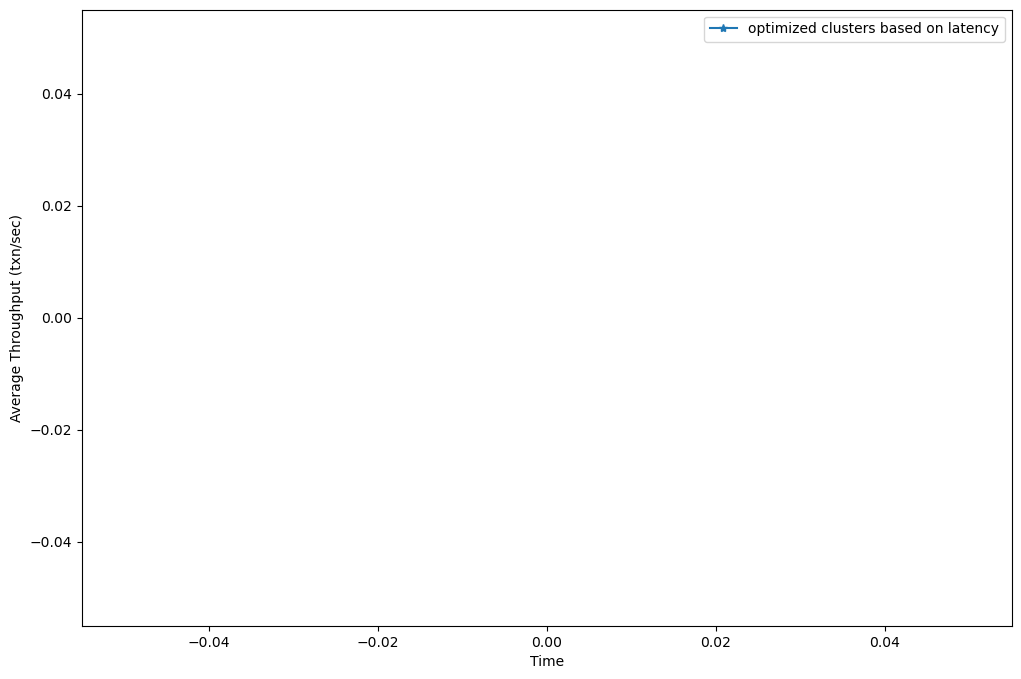

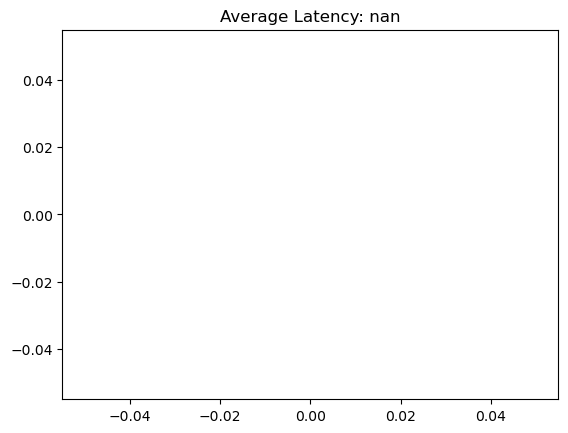

Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-19].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-20].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-21].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-22].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-23].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-24].
Deleted 

In [ ]:
for cfig in config_list:   
    if 2 > 1:

        os.system('rm node_info.csv')
        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        lines  = []



        for node_id in node_info_dict['node_id'].keys():
        #     print(node_id, node_info_dict['node_id'][node_id], node_info_dict['region'][node_id])

            lim = node_info_dict['node_id'][node_id]
            reg = node_info_dict['region'][node_id].strip().replace('\'', '')

        #     print(reg)

            cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
        #     cmd = 'gcloud compute instances create resdb-'+f"{lim:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-small --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

            lines.append(cmd)


        lines


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)


        instance_type = 'e2-small'


        redirect = '>'
        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')





        !cat all_internal_ips
        ! echo " " 
        # !cat all_external_ips



        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data1, data2

        data2, len(data2)

        data = []

        # for i in range(len(data1)):
        #     if data1[i]!='None':
        # #         data.append(data1[i] + '    ' + data2[i])
        #         data.append('127.0.0.1'+ '    ' + '127.0.0.1')


        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])
        #         data.append('127.0.0.1'+ '    ' + '127.0.0.1')

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict

        for item in node_info_dict['publicAndprivateIP']:
            print(node_info_dict['publicAndprivateIP'][item])

        with open('replicas.txt', 'w') as f:

            for item in node_info_dict['publicAndprivateIP']:

                if (node_info_dict['ServerOrClientregion'][item] ==0):
                    f.write("%s\n" % node_info_dict['publicAndprivateIP'][item])


        node_info_dict['ServerOrClientregion']

        ! cat replicas.txt

        with open('clients.txt', 'w') as f:

            for item in node_info_dict['publicIP']:

                if (node_info_dict['ServerOrClientregion'][item] ==1):
                    f.write("%s\n" % node_info_dict['publicIP'][item])

        os.system('cat clients.txt')

        node_info_dict

        # def run_server_node_remote(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None' and( ip in nodeIps):


        #         current = (ip.split('.'))
        #         command = './examples/hotstuff-app --conf hotstuff.gen-sec'+str(nodeIps.index(ip))+'.conf '

        #         print(i,command)



        # for i in range(len(lines)):
        #     print(i)
        #     run_server_node_remote(i)




        # def run_client_node_remote(i):
        #     ip = lines[i]
        #     if ip!='None' and( ip in clientIps):

        #         current = (ip.split('.'))
        #         command = './examples/hotstuff-client --idx 0 --iter -1 --max-async 5 >../nohup.out 2>&1 &"'

        #         print(command)

        # for i in range(len(lines)):
        #     print(i)
        #     run_client_node_remote(i)


        # # # os.system('echo 3108 | sudo -S ls')/FinalKeys.pem

        # # experiment = 'exp_f1'

        # # os.system('echo 3108 | sudo -S sh job_mini1.sh '+experiment)

        # # os.system('./run_cli.sh new '+experiment+'_cli;')
        # # os.system('sleep 30;')
        # # kill_nodes(3)

        # # # run_server_node(3)

        # # os.system('sleep 30;')

        # # os.system('./run_cli.sh stop '+experiment+'_cli;')
        # # os.system('./run.sh stop '+experiment+';')
        # # os.system('./run_cli.sh fetch '+experiment+'_cli;')
        # # os.system('cat '+experiment+'_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')



        # def run_server_node(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None':

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd /home/ubuntu/testbed/'+experiment+'/0/conf/; sudo nohup ../../../../libhotstuff/examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'+experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)


        # def run_node(i):
        #     ip = lines[i]
        # #     if ip!='None' and( ip in nodeIps[:-3]):
        #     if ip!='None' and ip in lines[:nnodes]:

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf > ../temp/nohup_'+str(i)+'.out 2>&1 &'

        #         print(command)
        #         os.system(command)


        # def run_client(i):
        #     ip = lines[i]
        #     client_no = i - nnodes
        #     if ip!='None' and( ip in lines[nnodes:]):

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'.out 2>&1 &'

        #         print(command)
        #         os.system(command)



        # def run_client2(i):
        #     ip = lines[i]
        #     client_no = i - nnodes
        #     if ip!='None' and( ip in lines[nnodes:]):

        #         current = (ip.split('.'))
        #         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'_2.out 2>&1 &'

        #         print(command)
        #         os.system(command)



        # # def run_join_node(i):
        # #     ip = lines[i]
        # #     if ip!='None':

        # #         current = (ip.split('.'))
        # #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'
        # #         +experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        # #         print(command)
        # #         os.system(command)




        # # def kill_nodes(i):
        # #     ip = lines[i]

        # #     if ip!='None':
        # #         current = (ip.split('.'))
        # #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'

        # #         output = subprocess.getoutput(command)
        # #         print(output)





        # # # run_server_node(3)

        # # # current



        # # os.system('cat exp_4c5n_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')


        def setup_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'

                print(command)

                output = os.system(command)
                print(output)


        def setup_remote2(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))



                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; git pull;"'

                print(command)

                output = os.system(command)
                print(output)


        def git_pull_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo git pull;"'


                output = subprocess.getoutput(command)
                print(output)



        # def run_join_node_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-1]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)



        # def run_join_node1_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-1]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)

        # def run_join_node2_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-2]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)

        # def run_join_node3_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip == nodeIps[-3]):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

        #         print(command)
        #         os.system(command)




        def kill_nodes_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))

                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                output = subprocess.getoutput(command)
                print(output)



        def clean_nodes_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))

                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm -f nohup.out;"'


                print(command)
                os.system(command)








        experiment = 'test'
        os.system('rm hotstuff.gen*')
        os.system('echo 3108 | sudo -S sh job_mini.sh '+ experiment)

        os.system('cp hotstuff.gen* ../../')

        import os
        os.system('cd ../../; git add .; git commit -m "Testing"; git push -f')


        # # def setup_remote3(i):

        # #     ip = node_info_dict['publicIP'][i] 
        # #     if ip!='None':
        # #         current = (ip.split('.'))
        # #         command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        # #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
        # #         print(command)

        # #         output = os.system(command)
        # #         print(output)


        # results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
        #                                                                        for i in [9])#node_info_dict['node_id'])


        # print(results)  

        time.sleep(60)


        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
                                                                               for i in node_info_dict['node_id'])


        print(results)  



        # for i in node_info_dict['publicIP']:
        #     print(i)
        #     setup_remote2(i)

        # compile_remote(0)



        def compile_remote(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


                print(command)
                output = os.system(command)
                print(output)






        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                               for i in list(node_info_dict['node_id'].keys()))


        print(results)  

        time.sleep(200)

        # def compile_remote(i):

        #     ip = node_info_dict['publicIP'][i] 
        #     if ip!='None':
        #         current = (ip.split('.'))
        #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


        # #         output = os.system(command)
        #         print(command)


        # for i in range(60):
        #     compile_remote(i)

        # time.sleep(420)




        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                               for i in node_info_dict['node_id'])


        print(results)  


        # node_info_dict

        def run_server_node_remote(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps[:-3]):

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'

                print(i,command)
                os.system(command)


        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_server_node_remote)(i)\
                                                                               for i in node_info_dict['node_id'])

        print(results)  
        time.sleep(45)


        # for i in node_info_dict['publicIP']:
        #     kill_nodes_remote(i)

        # def run_client_node_remote_print(i):
        #     ip = node_info_dict['publicIP'][i] 

        #     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 5 >../nohup.out 2>&1 &"'

        #         print(command)

        # for i in node_info_dict['publicIP']:
        #     run_client_node_remote_print(i)

        # def run_server_node_remote(i):
        #     ip = node_info_dict['publicIP'][i] 
        # #     if ip!='None' and( ip in nodeIps[:-3]):

        #     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'

        #         print(i,command)
        # #         os.system(command)

        # f



        def run_client_node_remote(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 400 >../nohup.out 2>&1 &"'


                print(command)
                os.system(command)




        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                               for i in node_info_dict['node_id'])

        print(results)  


        # for i in node_info_dict['publicIP']:
        #     run_client_node_remote(i)

        time.sleep(150)

        results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(kill_nodes_remote)(i)\
                                                                               for i in node_info_dict['publicIP'])


        os.system('cd ../../../dump_files; echo 3108 | sudo -S  rm *')

        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../../../dump_files/nohup_server_'+str(node_info_dict['ServerID'][i])+'.out'
                print(command)
                os.system(command)
                break

        # result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


        # result = result.decode("utf-8") 

        # lines = result.split('\n')

        # #     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
        # commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

        # Times = []
        # lats = []

        # for line in lines:
        #     m = commit_pat.match(line)
        #     if m:
        # #             try:

        #             time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
        #             float((line.split(' ')[1]).split(':')[2])
        #             Times.append(time_item)        

        #             lats.append(float(m.group(2)))
        #             print(lats[-1])
        # #             except:

        # lines


        # def getThroughput(experiment):

        #     result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


        #     result = result.decode("utf-8") 

        #     lines = result.split('\n')

        #     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
        # #     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

        #     Times = []
        #     lats = []

        #     for line in lines:
        #         m = commit_pat.match(line)
        #         if m:
        #             try:

        #                 time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
        #                 float((line.split(' ')[1]).split(':')[2])
        #                 Times.append(time_item)        

        #                 lats.append(float(m.group(2)))
        # #                 print(lats[-1])
        #             except:
        #                 continue


        #     begin_time = None
        #     values = []
        #     interval = 1
        #     cnt = 0
        #     Times.sort()
        #     for timestamp in Times:
        #         if begin_time is None:
        #             begin_time = timestamp
        #             next_begin_time = timestamp +interval

        #         while timestamp >= next_begin_time:
        #             begin_time = next_begin_time
        #             next_begin_time += interval
        #             values.append(cnt)
        #             cnt = 0
        #         cnt += 1
        #     values.append(cnt)

        # #     lats, _ = remove_outliers(lats)
        # #     print(len(values))


        #     return np.arange(len(values))*interval,np.array(values)/interval, lats

        experiment = '../../dump_files'
        X,Y, lats = getThroughput(experiment)


        print(np.sum(Y)/len(Y), np.average(lats))

        lats

        lats

        np.sum(Y)

        s1, s2 = X[:-2],Y[:-2]

        np.average(s2[10:40]),np.average(lats[-33:-3])

        lats


        experiment = cfig

        if not os.path.exists('../../../Experiments/ho_'+experiment):
            os.mkdir('../../../Experiments/ho_'+experiment)

        os.system('cp -r ../../../dump_files ../../../Experiments/ho_'+experiment)    


        fig = pl.figure(figsize = (12, 8))
        fig.patch.set_facecolor('white')
        pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Average Throughput (txn/sec)')
        # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

        # pl.ylim(0,10000)
        pl.savefig('../../../Experiments/ho_'+experiment+ '/thput.png', dpi =150, bbox_inches = 0 )
        pl.show()
        pl.clf()

        pl.plot(lats)
        pl.title('Average Latency: '+str( np.round(np.average(lats),2) ))
    #     pl.ylim(0,1)
        pl.savefig('../../../Experiments/ho_'+experiment+ '/lats.png', dpi =150, bbox_inches = 0 )
        pl.show()
        pl.clf()





        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')   

#     except:
        
#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
#         continue


# lats

# os.system('grep -n -r "LatencyPlot: new node sending join request message" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Received first message with new node info" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Leader received with tentative sets from all peer nodes" ../../../dump_files/')        

# 1000*(32.776365 - 32.768622)

# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# os.system('grep -n -r "LatencyPlot: Received initial join message" ../../../dump_files/')        

# os.system('grep -n -r "Sending Join Init message with height" ../../../dump_files/')        

# 1000*(17.534818-17.534437)

# os.system('grep -n -r "LatencyPlot: Sent response to  initial join message" ../../../dump_files/')        


    
# os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

# 17.536482

In [10]:
# os.system('cp -r ../../../dump_files ../../../Experiments/ho_'+experiment)    


In [11]:
#         pl.plot(lats)


In [12]:
# os.system('grep -n -r "LatencyPlot: Received 1st MC message" ../../../dump_files/')

In [13]:
# os.system('grep -n -r "LatencyPlot: before sending first mc message" ../../../dump_files/')

In [14]:
# 1000*(32.676090-32.612236)

In [15]:
# os.system('grep -n -r "LatencyPlot: going to execute based on 2nd MC message" ../../../dump_files/')


# os.system('grep -n -r "LatencyPlot: Finished execution" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Processing message from client" ../../../dump_files/')    

In [16]:
# os.system('grep -n -r "LatencyPlot: before initial join message" ../../../dump_files/')    

In [17]:
# # os.system('grep -n -r "LatencyPlot: " ../../../dump_files/')

# 1000*(11.479877-11.479442), 1000*(11.484887-11.479877),1000*(56.048590-56.046569), 1000*(56.050021 - 56.048590)

# # exec, # first mc, #second mc

# 1000*(56.050377 - 56.050181), 1000*(56.049389-56.049025), 1000*(56.050875-56.049389), 1000*(56.046557-56.038591) 


# # with open('opt1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('opt1.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)
  
    








# # with open('equiCluster1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('equiCluster1.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)
  
    
    
    
# # with open('equiCluster.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)

    
# # with open('lat.npy', 'rb') as f:
# #     lat1 = np.load(f)
# #     lat2 = np.load(f)

    
    
# # with open('opt.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)


# fig = pl.figure(figsize = (12, 8))
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')

# # pl.plot(eq1,eq2, '-*', label = 'optimized clusters: equal clusters (7 (R1),7 (R2)')
# # pl.plot(lat1,lat2, '-*', label = 'optimized clusters: latency (9 (R1),5 (R2))')
# # pl.plot(opt1,opt2, '-*', label = 'optimized clusters: latency and heterogeneity (4 (R1),5 (R1), 5 (R2))')
# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Average Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,350)
# # pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

## Single Non-Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Single Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/NodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave

## Multiple Non Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==7:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==11:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.axvline(x=60, ls='--', color = 'green')
pl.axvline(x=80, ls='--', color = 'blue')

pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Multiple Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/MultiNodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave